## *MALARIA DETECTION USING CNNs*

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
from tensorflow import keras
from keras.layers import InputLayer, Conv2D, MaxPool2D, Flatten , Dense, BatchNormalization,Dropout

In [ ]:
from keras.models import Sequential

In [ ]:
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy

In [ ]:
from keras import layers

# *Dataset*

In [ ]:
dataset, dataset_info = tfds.load('malaria', as_supervised = True, with_info = True,
                                   split=["train"], shuffle_files=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incompleteSVV1ZE/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [ ]:
classes = ["Parasitized","Uninfected"]

In [ ]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir=PosixGPath('/tmp/tmpbem9tirdtfds'),
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear images},


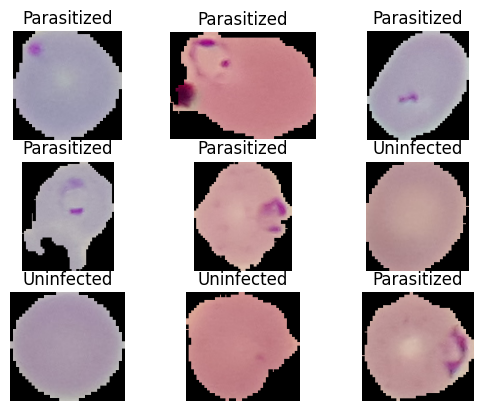

In [ ]:
for i,(image,label) in enumerate(dataset[0].take(9)): # Uninfected --> 1  Parasitzed --> 0
  ax = plt.subplot(3,3,i+1)
  plt.imshow(image)
  plt.title(classes[label.numpy()])
  plt.axis('off')

# *Data Preprocessing*

In [ ]:
def split(dataset, train_split, val_split):
  n = len(dataset)
  train_dataset = dataset.take(int(train_split*n))
  X = dataset.skip(int(train_split*n))
  val_dataset = X.take(int(val_split*n))
  test_dataset = X.skip(int(val_split*n))
  return train_dataset, val_dataset, test_dataset

In [ ]:
train_dataset, val_dataset, test_dataset = split(dataset[0],0.8,0.1)

In [ ]:
image_size = 224
def resize_rescale(image, label):
  return tf.image.resize(image,(image_size,image_size))/255. , label

In [ ]:
train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)

In [ ]:
for (image,label) in train_dataset.take(1):
  print(image)
  print(label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32)
tf.Tensor(0, shape=(), dtype=int64)


In [ ]:
batch_size = 32
train_dataset = train_dataset.shuffle(buffer_size=8,
                                      reshuffle_each_iteration=True).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
test_dataset = test_dataset.batch(batch_size)

# ***CNN Model Building***
# *Resnet Architecture*

In [ ]:
class ResNetBlock(layers.Layer):
    def __init__(self, filters, kernel_size, strides, activation : str):
        super().__init__()
        self.layer1 = Conv2D(kernel_size=kernel_size, filters = filters,
                            padding='same',activation=activation)
        self.layer2 = Conv2D(kernel_size=kernel_size, filters = filters,
                            padding='same',activation=activation)
        self.BatchNorm = BatchNormalization(),

    def __call__(self,x):
        a = self.layer1(x)
        b = self.layer2(a)
        return b+a

In [ ]:
class UpDownBlock(layers.Layer):
    def __init__(self):
        super().__init__()
        self.Layer1 = MaxPool2D(pool_size=2, strides=2)
        self.Layer2 = BatchNormalization()
    def __call__(self, x):
        M = Sequential([self.Layer1, self.Layer2])
        return M(x)

In [ ]:
class Classifier(layers.Layer):
    def __init__(self):
        super().__init__()
        self.Layer1 = Dense(units = 64, activation = "relu")
        self.Layer2 = Dense(units = 16, activation = "relu")
        self.Layer3 = Dense(units = 8, activation = "relu")
        self.Layer4 = Dense(units = 1, activation = "sigmoid")

    def __call__(self,x):
        L = Sequential([Flatten(),
                        self.Layer1,
                        self.Layer2,
                        self.Layer3,
                        self.Layer4])
        return L(x)

In [ ]:
model = Sequential([
                    InputLayer(input_shape=(224,224,3)),
                    ResNetBlock(8,3,1,'relu'),
                    UpDownBlock(),
                    ResNetBlock(16,3,1,'relu'),
                    UpDownBlock(),
                    ResNetBlock(32,3,1,'relu'),
                    UpDownBlock(),
                    ResNetBlock(64,3,1,'relu'),
                    UpDownBlock(),
                    Classifier()
                    ])

In [ ]:
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_66 (Conv2D)          (None, 224, 224, 8)       224       
                                                                 
 conv2d_67 (Conv2D)          (None, 224, 224, 8)       584       
                                                                 
 tf.__operators__.add_13 (T  (None, 224, 224, 8)       0         
 FOpLambda)                                                      
                                                                 
 sequential_24 (Sequential)  (None, 112, 112, 8)       32        
                                                                 
 conv2d_68 (Conv2D)          (None, 112, 112, 16)      1168      
                                                                 
 conv2d_69 (Conv2D)          (None, 112, 112, 16)      2320      
                                                     

In [ ]:
model.compile(Adam(learning_rate=0.001),
              loss = BinaryCrossentropy(),
              metrics = 'accuracy')

# *Model Training*

In [ ]:
history = model.fit(train_dataset, validation_data = val_dataset, epochs = 5, verbose = 1)

Epoch 1/5
689/689 [==============================] - 56s 76ms/step - loss: 0.2665 - accuracy: 0.8916 - val_loss: 0.2622 - val_accuracy: 0.9162
Epoch 2/5
689/689 [==============================] - 47s 68ms/step - loss: 0.1390 - accuracy: 0.9544 - val_loss: 0.1406 - val_accuracy: 0.9521
Epoch 3/5
689/689 [==============================] - 56s 81ms/step - loss: 0.1218 - accuracy: 0.9594 - val_loss: 0.1328 - val_accuracy: 0.9608
Epoch 4/5
689/689 [==============================] - 51s 74ms/step - loss: 0.1094 - accuracy: 0.9630 - val_loss: 0.1662 - val_accuracy: 0.9426
Epoch 5/5
689/689 [==============================] - 47s 69ms/step - loss: 0.0977 - accuracy: 0.9669 - val_loss: 0.1201 - val_accuracy: 0.9619


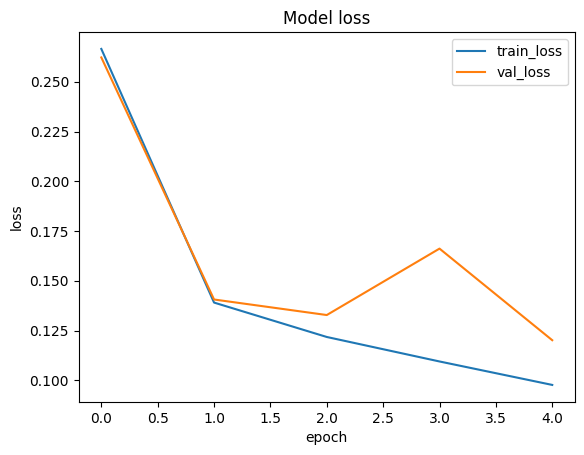

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'])
plt.show()

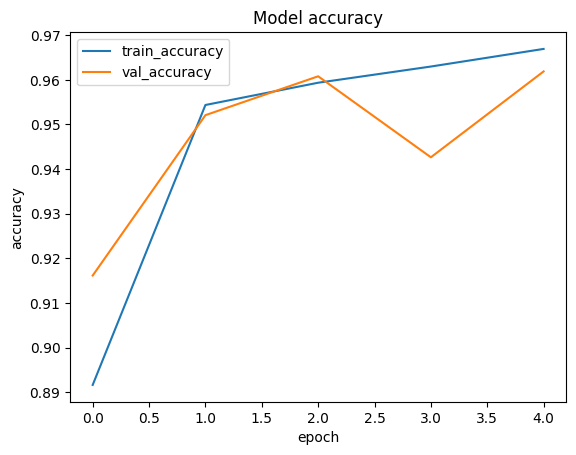

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy','val_accuracy'])
plt.show()

# *Model Evaluation*

In [ ]:
model.predict(test_dataset.take(1))[0][0] # Our CNN model gives an output between 0 and 1.

1/1 [==============================] - 11s 11s/step


0.9861268

In [ ]:
for (image,label) in test_dataset.take(1):
  print(label)
  print(model.predict(image)) # So if the output is greater than 0.5, it is uninfected.

tf.Tensor([1 0 0 1 0 1 0 1 0 0 0 1 1 0 1 0 1 1 0 0 0 1 0 1 1 0 1 1 1 0 1 1], shape=(32,), dtype=int64)
1/1 [==============================] - 0s 202ms/step
[[7.2821385e-01]
 [1.0623854e-03]
 [2.0461313e-05]
 [9.8289216e-01]
 [7.1894745e-03]
 [9.1957009e-01]
 [2.0408344e-04]
 [7.9475445e-01]
 [7.2707480e-05]
 [9.1892761e-01]
 [1.1089696e-04]
 [9.8965329e-01]
 [9.7001690e-01]
 [4.2395373e-03]
 [9.7182065e-01]
 [9.8400051e-05]
 [9.9379539e-01]
 [9.9387771e-01]
 [3.1966101e-02]
 [4.7772064e-06]
 [3.5643622e-01]
 [8.9745116e-01]
 [5.1811594e-07]
 [9.8002529e-01]
 [9.5226032e-01]
 [2.1384610e-02]
 [9.9343044e-01]
 [9.9467480e-01]
 [7.4464202e-01]
 [5.3081353e-04]
 [9.1552246e-01]
 [9.7864670e-01]]


In [ ]:
def output(x):
  if x >= 0.5:
    return "1(predicted)"
  else:
    return "0(predicted)"

1/1 [==============================] - 0s 28ms/step


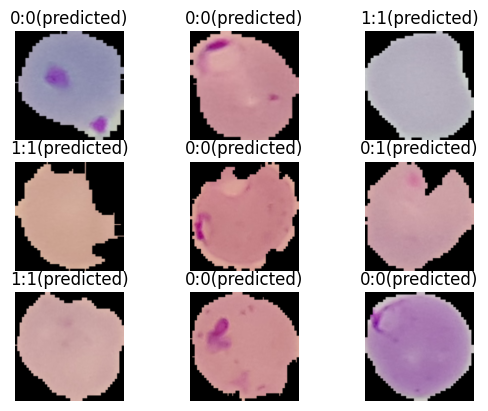

In [ ]:
for i,(image,label) in enumerate(test_dataset.take(9)):
  ax = plt.subplot(3,3,i+1)
  plt.imshow(image[0])
  plt.title((str(label.numpy()[0])) + ":" + str (output(model.predict(image)[0][0])))
  plt.axis('off')

In [ ]:
model.evaluate(test_dataset)

87/87 [==============================] - 15s 44ms/step - loss: 0.1429 - accuracy: 0.9568


[0.1429005265235901, 0.9568371176719666]

## **Saving Model Weights and Architecture**

In [ ]:
## Saving the model weights
model.save_weights("cnn_resnet.h5")

In [ ]:
cnn_resnet = model.to_json()

In [ ]:
## Saving the model architecture in ajson file
import json
with open('cnn_resnet.json', 'w') as f:
    json.dump(cnn_resnet, f)